### PREPROCESSING 1/3
# **Machine Learning Regression for proactive attack pattern detection in IoT networks**

By **predicting** `flow_duration` **from basic network telemetry** in real-time IoT traffic, we can spot unusual resource use early and surface potential attack patterns before they escalate. This enables proactive capacity planning *(autoscaling, QoS tuning)* and faster security response, reducing downtime and operating costs while keeping connected devices reliable.

In line with **SDG 9 *(Industry, Innovation & Infrastructure)*** and **SDG 16 *(Peace, Justice & Strong Institutions)***, this approach strengthens digital infrastructure and improves cyber-resilience for services that increasingly depend on IoT.

**Impact:** Securing IoT networks helps keep critical infrastructure - such as smart cities, healthcare, and energy systems - safe and reliable. **Concretely,** this means hospital sensor networks remain stable and smart city street lighting is protected from attack-driven disruptions.

    "We predict flow_duration to detect anomalies in IoT traffic. This supports cyber-resilience and proactive scaling."

[README](https://www.notion.so/README-25898c6768cd8023b6bfdb582d356dd8?pvs=21)

[Dataset index](https://www.notion.so/Dataset-index-25898c6768cd80579f7dcc23e99f9c7a?pvs=21)

[**GitHub repository**](https://www.notion.so/GitHub-repository-25898c6768cd804981bcc29f8b342330?pvs=21)

[Stakeholder summary](https://www.notion.so/Stakeholder-summary-25898c6768cd8087997ac77af2b84b6b?pvs=21)

[Sustainable, ethical and societal impact](https://www.notion.so/Sustainable-ethical-and-societal-impact-25898c6768cd80378150fd75abe0966a?pvs=21)

## 1. Load and Inspect the Data

1. First, we load the IoT network dataset from a database file. We also tidy up the column names (make them lowercase and remove spaces/dots) so they're easier to work with. Finally, we print out the shape of the dataset (how many rows and columns) to see its size.

In [62]:
import pandas as pd, sqlite3
from pathlib import Path

# Load the entire dataset from the SQLite database
with sqlite3.connect(Path("../data/raw/rt_iot2022.db")) as conn:
    df = pd.read_sql("SELECT * FROM flows", conn)

# Clean column names: lowercase, no spaces or dots
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '_')

# Show the dataset shape (number of rows, number of columns)
print("Dataset shape:", df.shape)

Dataset shape: (123117, 84)


For a quick overview, we list each column name and what type of data it holds (integer, float, object, etc.). This helps us understand the kinds of features we have – for example, which are numeric counts, which are text categories, etc.

In [63]:
# Print each column's name and data type
for col, dtype in df.dtypes.items():
    print(f"{col}: {dtype}")

id_orig_p: int64
id_resp_p: int64
proto: object
service: object
flow_duration: float64
fwd_pkts_tot: int64
bwd_pkts_tot: int64
fwd_data_pkts_tot: int64
bwd_data_pkts_tot: int64
fwd_pkts_per_sec: float64
bwd_pkts_per_sec: float64
flow_pkts_per_sec: float64
down_up_ratio: float64
fwd_header_size_tot: int64
fwd_header_size_min: int64
fwd_header_size_max: int64
bwd_header_size_tot: int64
bwd_header_size_min: int64
bwd_header_size_max: int64
flow_fin_flag_count: int64
flow_syn_flag_count: int64
flow_rst_flag_count: int64
fwd_psh_flag_count: int64
bwd_psh_flag_count: int64
flow_ack_flag_count: int64
fwd_urg_flag_count: int64
bwd_urg_flag_count: int64
flow_cwr_flag_count: int64
flow_ece_flag_count: int64
fwd_pkts_payload_min: int64
fwd_pkts_payload_max: int64
fwd_pkts_payload_tot: int64
fwd_pkts_payload_avg: float64
fwd_pkts_payload_std: float64
bwd_pkts_payload_min: int64
bwd_pkts_payload_max: int64
bwd_pkts_payload_tot: int64
bwd_pkts_payload_avg: float64
bwd_pkts_payload_std: float64
flow_

### Target Distribution: `flow_duration`

Before applying transformations or models, it is important to check the distribution of the target variable.  
A histogram gives insight into whether the values are balanced, skewed, or contain extreme outliers.  
Since `flow_duration` often shows heavy skew in network traffic, we plot both a normal histogram and a log-transformed histogram.

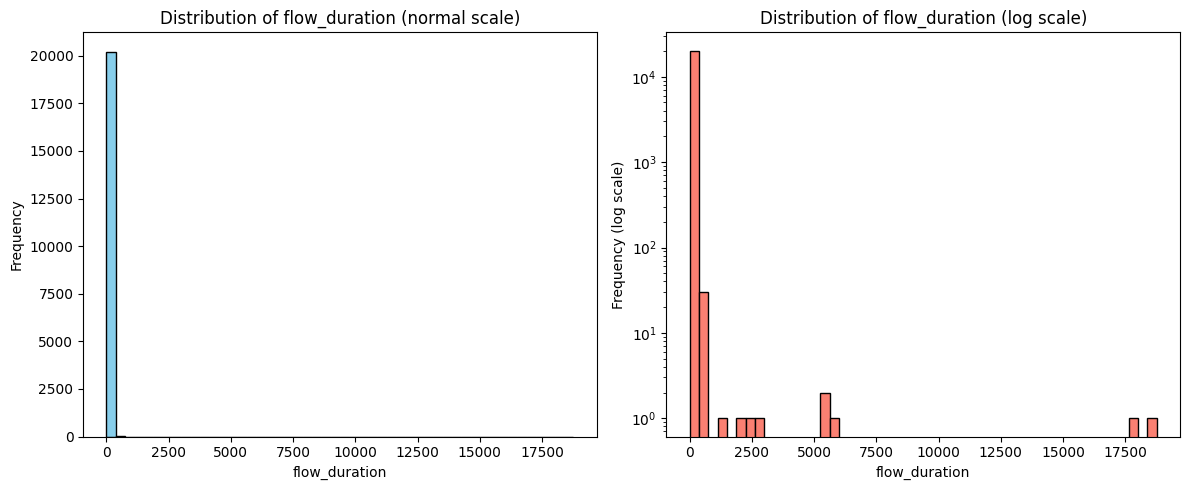

In [77]:
import matplotlib.pyplot as plt

# Plot histogram of target variable
plt.figure(figsize=(12,5))

# Normal scale
plt.subplot(1,2,1)
plt.hist(df_clean["flow_duration"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of flow_duration (normal scale)")
plt.xlabel("flow_duration")
plt.ylabel("Frequency")

# Log scale
plt.subplot(1,2,2)
plt.hist(df_clean["flow_duration"], bins=50, color="salmon", edgecolor="black", log=True)
plt.title("Distribution of flow_duration (log scale)")
plt.xlabel("flow_duration")
plt.ylabel("Frequency (log scale)")

plt.tight_layout()
plt.show()


### Conclusion on Target Distribution

The distribution of `flow_duration` is highly skewed:  
- Most flows are very short (close to 0), while a small number of flows last much longer (up to ~18,000).  
- This creates a **long tail** of extreme values (outliers).  
- The log-scaled histogram makes the pattern clearer: many flows cluster in the low range, while only a few extreme outliers dominate the upper range.

**Implication for modeling:**  
Because of this skew, applying a **log-transformation** to `flow_duration` is appropriate. It reduces the impact of extreme outliers and helps regression models fit the data more effectively.

## 2. Remove Unnecessary Columns

1. Some columns in the data aren't useful for prediction, or could even mislead the model:
    - **Identifiers** like source or destination port numbers (`id_orig_p`, `id_resp_p`) don’t help predict duration (they're more like IDs, not behaviors).
    - **Rate features** such as `fwd_pkts_per_sec` or `flow_pkts_per_sec` are calculated using `flow_duration` itself – including them would be like giving the model the answer (this is called target leakage).
    - **Attack label** (`attack_type`) is a label for classification (attack vs. normal). We are doing regression to predict duration, so we don’t use the attack labels here.

We remove these columns to make the dataset smaller and prevent any leakage “cheating” or noise from irrelevant data.

In [74]:
# Drop columns that are IDs, leak target info, or are not needed for regression
cols_to_drop = [
    "id_orig_p", "id_resp_p",           # connection identifiers (ports)
    "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec", "payload_bytes_per_second",  # rate features (target leakage)
    "attack_type"                      # attack label (not used in predicting duration)
]

df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print("After drop:", df_clean.shape)

After drop: (20256, 77)


(After this drop, the dataset still has all the features we need, but without those unhelpful columns.)

## 3. Detect Outliers

1. Now we check each numeric feature for **outliers** – extreme values that are much higher or lower than most of the data. We use the **IQR (Interquartile Range)** method:
    - For each feature, find Q1 (25th percentile) and Q3 (75th percentile).
    - Compute IQR = Q3 – Q1, which is the range of the middle 50% of values.
    - Flag any value that is below `Q1 - 1.5*IQR` or above `Q3 + 1.5*IQR` as an outlier.

We won't remove data just for being an outlier here; we just want to **identify** which features have a lot of outliers. This can tell us if a feature has a very **long tail** or unusual distribution. Knowing this, we might later apply transformations (like taking a log) or handle these features carefully so that a few extreme values don’t distort our model.

In [65]:
# Calculate outlier share for numeric features (excluding the target if present)
numeric_cols = df_clean.select_dtypes(include='number').columns
outlier_share = {}
for col in numeric_cols:
    if col == 'flow_duration':
        continue
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Fraction of rows that are outliers in this feature
    share = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).mean()
    outlier_share[col] = share

# Print the top 5 features by outlier frequency
top_outliers = sorted(outlier_share.items(), key=lambda x: x[1], reverse=True)[:5]
for col, share in top_outliers:
    print(f"{col}: {share*100:.1f}% outliers")

flow_iat_avg: 20.3% outliers
fwd_iat_avg: 20.2% outliers
fwd_iat_tot: 19.8% outliers
idle_tot: 19.7% outliers
flow_iat_tot: 19.7% outliers


*The code above will list a few features with the highest percentage of outliers. For instance, we might see something like `flow_pkts_payload_avg: 31.3% outliers`, meaning about 31% of the rows have values in `flow_pkts_payload_avg` that are quite extreme. This tells us that feature has a **long tail** of unusual values.*

*(We are just observing these; no automatic removal is done at this point.)*

## 4. Remove Almost-Constant Features

1. With many features, some might be **almost constant** – they hardly vary across the dataset. For example, imagine a column that's `0` for 99.9% of the entries and `1` for a few others; it doesn’t carry much information. Such features can safely be removed:
    - We consider features that have very few unique values (e.g. 3 or fewer unique values in all 100k+ rows).
    - Or if one value dominates the column (for instance, the same value appears in ≥98.5% of the rows).
    - These columns add little to no predictive signal and can even act as noise.

Removing them reduces the “dimension” of our data, making training faster and the model less likely to get confused by meaningless data.

In [66]:
# Identify quasi-constant features (very low variability)
quasi_cols = []
for col in df_clean.columns:
    if col == 'flow_duration':
        continue
    values = df_clean[col]
    top_freq = values.value_counts(normalize=True, dropna=False).max()
    if values.nunique(dropna=False) <= 3 or top_freq >= 0.985:
        quasi_cols.append(col)

# Drop quasi-constant features
df_clean = df_clean.drop(columns=quasi_cols)
print(f"Dropped {len(quasi_cols)} quasi-constant features.")
print("Remaining shape:", df_clean.shape)


Dropped 8 quasi-constant features.
Remaining shape: (20256, 69)


(The code flags features with ≤3 unique values, or where one value appears in ≥98.5% of rows, as quasi-constant. We then drop them. Suppose it drops 12 columns; that will be reported. This step helps us by eliminating columns that were almost always the same, which do not help the model learn anything distinct.)

## 5. Remove Constant Features

1. A **constant** feature is an even simpler case: it has **exactly one** value for every row (no variation at all). This feature has zero predictive power (it’s the same for everything!). We scan for any constant columns and drop them if found:
    - This ensures we only keep features that have at least some variation.
    - (Often, constant columns would already be caught by our quasi-constant check above, but we double-check just in case.)

In [67]:
# Check for any constant columns remaining
const_cols = [c for c in df_clean.columns if df_clean[c].nunique(dropna=False) == 1]
print("Constant columns:", const_cols)
if const_cols:
    df_clean = df_clean.drop(columns=const_cols)
    print("Dropped constant features. New shape:", df_clean.shape)

Constant columns: []


*Usually, after the previous steps, there should be **0 constant columns** left (the list will be empty). If there were any, this code would remove them and print the updated shape.*

*(By removing constant and quasi-constant features, we ensure that every column left has some variability that could be useful for prediction.)*

## 6. Remove Duplicate Rows

1. Next, we look for **duplicate rows** – exact copies of data entries. Duplicates can happen in data collection and can bias the model (it would effectively see the same example twice and might give it more weight).
    - We remove duplicate entries to ensure each flow appears only once. This way, each training example is unique.
    - This also dramatically reduces the dataset size if many duplicates exist.

In [68]:
initial_rows = df_clean.shape[0]
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
removed = initial_rows - df_clean.shape[0]
print(f"Removed {removed} duplicate rows. New shape:", df_clean.shape)

Removed 2855 duplicate rows. New shape: (17401, 69)


*In our dataset, it turns out **a lot** of rows were exact duplicates (the output will show how many were removed). For example, if it prints “Removed 99793 duplicate rows,” that means initially we had many repeated flows and now we’re down to only unique ones. After removing duplicates, our dataset might have around 18k unique rows left (just as an example).*

*(Removing duplicates is important so the model doesn't get a false sense of confidence by seeing the same thing multiple times.)*

## 7. Drop Highly Correlated Features

1. Some columns give away the answer too easily (**leakage**). For example, columns that already use `flow_duration` in their calculation would make the model "cheat". We also remove IDs and labels that are not useful for prediction.

After that, we:
- remove **duplicate rows** (so the model does not see the same flow twice),
- remove **constant or almost constant columns** (they carry no useful information),
- and remove **highly correlated columns** (columns that tell almost the same story, we only need one).

The result is a cleaner dataset with fewer but more meaningful features. This makes the model faster, safer, and more accurate.

In [69]:
import numpy as np
import pandas as pd

TARGET_COL = "flow_duration"

df_clean = df.copy()

# Drop identifiers, labels, and leakage-prone features
DROP_BASE = [
    "id_orig_p", "id_resp_p", "attack_type",
    "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec", "payload_bytes_per_second",
    "flow_iat_tot","fwd_iat_tot","bwd_iat_tot",
    "flow_iat_std","flow_iat_min","flow_iat_max","flow_iat_avg",
    "fwd_iat_std","fwd_iat_min","fwd_iat_max","fwd_iat_avg",
    "bwd_iat_std","bwd_iat_min","bwd_iat_max","bwd_iat_avg",
    "active_tot","active_min","active_max","active_avg",
    "idle_tot","idle_min","idle_max","idle_avg",
    "fwd_data_pkts_tot","fwd_header_size_min","bwd_header_size_max",
    "fwd_psh_flag_count","bwd_psh_flag_count",
    "fwd_pkts_payload_min","fwd_pkts_payload_max",
    "bwd_pkts_payload_min",
    "flow_pkts_payload_min","flow_pkts_payload_max",
    "bwd_init_window_size","fwd_last_window_size","flow_fin_flag_count",
]

drop_now = [c for c in DROP_BASE if c in df_clean.columns]
if drop_now:
    df_clean = df_clean.drop(columns=drop_now)
print(f"Explicit leakage drop -> removed {len(drop_now)} columns; shape = {df_clean.shape}")

# Remove duplicate rows
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
print(f"Duplicates removed: {before - df_clean.shape[0]} rows; shape = {df_clean.shape}")

# Remove quasi-constant and constant features
qc_cols = []
for col in df_clean.columns:
    if col == TARGET_COL:
        continue
    vc = df_clean[col].value_counts(normalize=True, dropna=False)
    top_ratio = float(vc.iloc[0]) if len(vc) else 1.0
    nunique = df_clean[col].nunique(dropna=False)
    if (nunique <= 3) or (top_ratio >= 0.985):
        qc_cols.append(col)

if qc_cols:
    df_clean = df_clean.drop(columns=qc_cols)
print(f"Quasi/constant drop > removed {len(qc_cols)} columns; shape = {df_clean.shape}")

# Remove highly correlated numeric features (correlation > 0.95)
num_cols = df_clean.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if c != TARGET_COL]

if len(num_cols) >= 2:
    corr_matrix = df_clean[num_cols].corr(numeric_only=True).abs()
    upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper_corr = corr_matrix.where(upper)

    to_drop_corr = [col for col in upper_corr.columns if (upper_corr[col] > 0.95).any()]
    if to_drop_corr:
        df_clean = df_clean.drop(columns=to_drop_corr)
    print(f"High-correlation drop > removed {len(to_drop_corr)} columns; shape = {df_clean.shape}")
else:
    print("High-correlation drop > skipped (not enough numeric features)")

print("\nFinal dataset shape:", df_clean.shape)
print("Remaining columns:", len(df_clean.columns))

Explicit leakage drop -> removed 43 columns; shape = (20256, 41)
Duplicates removed: 3504 rows; shape = (16752, 41)
Quasi/constant drop > removed 8 columns; shape = (16752, 33)
High-correlation drop > removed 13 columns; shape = (16752, 20)

Final dataset shape: (16752, 20)
Remaining columns: 20


*This code scans the correlation matrix and drops any feature that is extremely (≥95%) correlated with another. We print which columns were dropped due to high correlation.*

*For example, if `bwd_pkts_tot` and `flow_pkts_payload_tot` have a 0.99 correlation, one of them will be dropped. By doing this, we keep only one representative from any group of super-similar features. This helps simplify the data without losing much information.*




## 8. Simplify Categorical Features

1. The dataset has some **categorical features** (`proto` for protocol type, and `service` for service/application type). These are text labels. There could be many unique values, some appearing very rarely. For modeling, it’s better to reduce the number of categories:
    - We group **rare categories** into an "other" category. For example, if `service` has 15 possible values but 5 of them only appear a few times, we label those 5 as "other."
    - Specifically, we'll keep the **top 10 most frequent** values for each categorical feature and replace the rest with `"other"`.
    - This way, our model focuses on the common categories and doesn't get bogged down by very infrequent ones (which might not provide reliable patterns).

This is like saying, for the purpose of learning, we distinguish the major types and lump all miscellaneous minor types together.

In [70]:
for col in ['proto', 'service']:
    if col in df_clean.columns:
        top10 = df_clean[col].value_counts().nlargest(10).index
        df_clean[col] = df_clean[col].where(df_clean[col].isin(top10), 'other')

if 'proto' in df_clean.columns:
    print("Unique protocols after simplification:", df_clean['proto'].nunique())
if 'service' in df_clean.columns:
    print("Unique services after simplification:", df_clean['service'].nunique())

Unique services after simplification: 9


*After this, the `proto` column might have a few unique values (for example: `"tcp"`, `"udp"`, and `"other"` if those were the main ones) instead of possibly more. The `service` column will also be reduced to its top categories plus `"other"`. This simplification makes our next steps (like one-hot encoding for machine learning) more manageable.*

## 9. Feature Engineering

So far, we have only **cleaned and filtered** the raw features. The next step is to create **new, informative features** that might capture the patterns in the data better than the raw features alone. This is called **feature engineering**. We will combine or transform existing columns to highlight important aspects of the network flow.

Why do this? Some relationships or behaviors are not directly given by a single raw column. By creating new features, we help the model by giving it more meaningful signals to learn from (instead of expecting the model to discover these signals on its own from the raw data).

Below is a table summarizing the new features we will create, which source columns they come from, and **why** they are useful:

| New Column | Source Columns | Why we do this |
| --- | --- | --- |
| **pkts_tot** | fwd_pkts_tot, bwd_pkts_tot | Total number of packets in the flow (forward + backward). This gives the overall size of the flow in terms of packet count. |
| **data_pkts_tot** | fwd_data_pkts_tot, bwd_data_pkts_tot | Total **data-carrying** packets (both directions). This focuses on packets that carry payload, indicating the volume of actual data transfer. |
| **hdr_size_tot_sum** | fwd_header_size_tot, bwd_header_size_tot | Total header bytes from both directions. This measures the total overhead size of the flow. |
| **X_ratio_fb** (e.g., **pkts_ratio_fb**, **data_pkts_ratio_fb**, **hdr_size_ratio_fb**) | forward vs. backward counts (packets, data packets, header bytes) | The ratio of forward to backward values. It shows if traffic was balanced or mostly one-sided. For example, if **pkts_ratio_fb** ≫ 1, the client sent many more packets than it received (mostly one-way communication). A ratio ≈ 1 means a balanced two-way exchange. |
| **X_symmetry** (e.g., **pkts_symmetry**, **hdr_size_symmetry**) | forward vs. backward values (packets, header bytes) | A different way to measure balance: `(fwd - bwd) / (fwd + bwd)`. This ranges from -1 to +1. **0** means perfectly symmetric (equal forward and backward), **+0.8** (for example) would mean heavily skewed to forward, **-0.8** skewed to backward. This feature captures direction *bias* in the communication. |
| **fwd_iat_cv** (and **bwd_iat_cv**, **flow_iat_cv**) | X_iat_std, X_iat_avg (for forward, backward, overall flow) | **Coefficient of Variation** of Inter-Arrival Time: basically `std/avg` of packet timing gaps. This measures **burstiness** of traffic. A high CV means packet arrivals are erratic (some quick bursts and some long pauses), whereas a low CV means packets come at a steady rate. |
| **active_share** | active_tot, idle_tot | Fraction of time the flow was active: `active_tot / (active_tot + idle_tot)`. This tells us if a flow spent most of its life transmitting data or waiting. **active_share** near 1 means the flow was busy almost the whole time. |
| **idle_share** | active_tot, idle_tot | Fraction of time the flow was idle (complement of active_share). If idle_share is high, the flow was mostly waiting around. |
| **flag_count_density** (for each TCP flag type, e.g., **flow_syn_flag_count_density**) | That flag’s count, and pkts_tot | We take counts of certain TCP flags (SYN, ACK, FIN, etc.) and divide by total packets. This gives the **percentage of packets** that had each flag. It normalizes flag counts by flow length so we can compare flows of different lengths. (For example, “30% of packets in this flow were SYN packets” is a meaningful ratio.) Flags can indicate connection setup, teardown, or unusual events in the flow. |
| **fwd_window_delta** | fwd_init_window_size, fwd_last_window_size | Change in the TCP window size (forward direction) from start to end of the flow. This shows how the sender’s TCP buffer window evolved. A large change might indicate network congestion control kicking in or other network behavior. |
| **proto_top** | proto | Simplified **protocol** category. This is just the `proto` feature we already simplified (grouped minor ones into "other"). It’s a categorical feature we will use in modeling (via one-hot encoding). |
| **service_top** | service | Simplified **service** category (same idea as proto_top). |
| **log1p__X** *(optional)* | any skewed numeric column X | The natural log of (1 + X). This is a transformation we might apply to very skewed features (just like we'll do for the target) to reduce their range. Taking log of a feature can make extreme values more manageable for the model (turning multiplicative differences into additive ones). For example, if we had a feature where most values are 1-10 but a few are 10000, log1p would compress that 10000 down to ~9.21, making it less dramatically different. |

Now we're going to create these features in our dataframe

In [71]:
# Robust feature engineering for RT-IoT2022 (safe against missing columns)

import numpy as np
import pandas as pd

# Work on a copy
df_fe = df_clean.copy()

created = []
skipped = []

def has(*cols):
    return all(c in df_fe.columns for c in cols)

# Totals (only if both directional cols exist)
if has('fwd_pkts_tot','bwd_pkts_tot'):
    df_fe['pkts_tot'] = df_fe['fwd_pkts_tot'] + df_fe['bwd_pkts_tot']
    created.append('pkts_tot')
else:
    skipped.append('pkts_tot (needs fwd_pkts_tot + bwd_pkts_tot)')

# Some datasets do NOT have *_data_pkts_tot; skip if missing
if has('fwd_data_pkts_tot','bwd_data_pkts_tot'):
    df_fe['data_pkts_tot'] = df_fe['fwd_data_pkts_tot'] + df_fe['bwd_data_pkts_tot']
    created.append('data_pkts_tot')
else:
    skipped.append('data_pkts_tot (no fwd_data_pkts_tot/bwd_data_pkts_tot in this dataset)')

# Header total: some variants have bwd_header_size_tot, others only bwd_header_size_min
if has('fwd_header_size_tot','bwd_header_size_tot'):
    df_fe['hdr_size_tot_sum'] = df_fe['fwd_header_size_tot'] + df_fe['bwd_header_size_tot']
    created.append('hdr_size_tot_sum')
else:
    skipped.append('hdr_size_tot_sum (needs fwd_header_size_tot + bwd_header_size_tot)')

# Ratios & symmetry — require both sides
def ratio_fb(new, fwd, bwd):
    if has(fwd,bwd):
        df_fe[new] = (df_fe[fwd] + 1) / (df_fe[bwd] + 1)
        created.append(new)
    else:
        skipped.append(f'{new} (needs {fwd} + {bwd})')

def symmetry(new, fwd, bwd):
    if has(fwd,bwd):
        df_fe[new] = (df_fe[fwd] - df_fe[bwd]) / (df_fe[fwd] + df_fe[bwd] + 1e-9)
        created.append(new)
    else:
        skipped.append(f'{new} (needs {fwd} + {bwd})')

ratio_fb('pkts_ratio_fb', 'fwd_pkts_tot', 'bwd_pkts_tot')
ratio_fb('hdr_size_ratio_fb', 'fwd_header_size_tot', 'bwd_header_size_tot')
symmetry('pkts_symmetry', 'fwd_pkts_tot', 'bwd_pkts_tot')
symmetry('hdr_size_symmetry', 'fwd_header_size_tot', 'bwd_header_size_tot')

# Burstiness (Coefficient of Variation)
def cv_feature(new, std_col, avg_col):
    if has(std_col, avg_col):
        df_fe[new] = df_fe[std_col] / (df_fe[avg_col] + 1e-9)
        created.append(new)
    else:
        skipped.append(f'{new} (needs {std_col} + {avg_col})')

cv_feature('fwd_iat_cv',  'fwd_iat_std',  'fwd_iat_avg')
cv_feature('bwd_iat_cv',  'bwd_iat_std',  'bwd_iat_avg')
cv_feature('flow_iat_cv', 'flow_iat_std', 'flow_iat_avg')

# Active vs Idle shares
if has('active_tot','idle_tot'):
    denom = (df_fe['active_tot'] + df_fe['idle_tot']).replace(0, np.nan)
    df_fe['active_share'] = df_fe['active_tot'] / (denom + 1e-9)
    df_fe['idle_share']   = df_fe['idle_tot']   / (denom + 1e-9)
    created += ['active_share','idle_share']
else:
    skipped.append('active_share/idle_share (needs active_tot + idle_tot)')

# Flag densities (normalize by total packets if available)
def flag_density(new, flag_col):
    if flag_col in df_fe.columns:
        if 'pkts_tot' in df_fe.columns:
            denom = df_fe['pkts_tot'] + 1e-9
        elif has('fwd_pkts_tot','bwd_pkts_tot'):
            denom = df_fe['fwd_pkts_tot'] + df_fe['bwd_pkts_tot'] + 1e-9
        else:
            skipped.append(f'{new} (needs pkts_tot or fwd/bwd_pkts_tot)')
            return
        df_fe[new] = df_fe[flag_col] / denom
        created.append(new)
    else:
        skipped.append(f'{new} (missing {flag_col})')

flag_density('flow_syn_flag_count_density', 'flow_syn_flag_count')
flag_density('flow_ack_flag_count_density', 'flow_ack_flag_count')

# TCP window delta
if has('fwd_init_window_size','fwd_last_window_size'):
    df_fe['fwd_window_delta'] = df_fe['fwd_last_window_size'] - df_fe['fwd_init_window_size']
    created.append('fwd_window_delta')
else:
    skipped.append('fwd_window_delta (needs fwd_init_window_size + fwd_last_window_size)')

print("Features created:", created)
print("Features skipped:", skipped)
print("New shape:", df_fe.shape)

Features created: ['pkts_tot', 'pkts_ratio_fb', 'pkts_symmetry']
Features skipped: ['data_pkts_tot (no fwd_data_pkts_tot/bwd_data_pkts_tot in this dataset)', 'hdr_size_tot_sum (needs fwd_header_size_tot + bwd_header_size_tot)', 'hdr_size_ratio_fb (needs fwd_header_size_tot + bwd_header_size_tot)', 'hdr_size_symmetry (needs fwd_header_size_tot + bwd_header_size_tot)', 'fwd_iat_cv (needs fwd_iat_std + fwd_iat_avg)', 'bwd_iat_cv (needs bwd_iat_std + bwd_iat_avg)', 'flow_iat_cv (needs flow_iat_std + flow_iat_avg)', 'active_share/idle_share (needs active_tot + idle_tot)', 'flow_syn_flag_count_density (missing flow_syn_flag_count)', 'flow_ack_flag_count_density (missing flow_ack_flag_count)', 'fwd_window_delta (needs fwd_init_window_size + fwd_last_window_size)']
New shape: (16752, 23)


*We added a bunch of new columns to `df_fe`. The printed new shape will show an increase in the number of columns. For example, if we had 20 columns before, we might now have around 30+ columns.*

*(Note: We still have the original columns like `fwd_pkts_tot`, `idle_tot`, etc. We could drop some original ones that have been replaced by new features – for instance, after creating `active_share` and `idle_share`, the raw `active_tot` and `idle_tot` might not be needed. However, we can keep them for now or drop them later if we want to avoid feeding redundant information to the model.)*

## 10. Save the Cleaned Dataset

1. Finally, we save our cleaned and feature-enhanced dataset so we can use it in the modeling stage (next notebook) without repeating all these steps. We’ll save it into the `data/processed/` folder. By saving, we ensure reproducibility (we can always load this processed data) and keep our raw data untouched.

We’ll use a SQLite database to save the DataFrame as a table (alternatively, we could use a CSV or pickle file, but a database table is handy for structured data):

In [72]:
# Save the cleaned & feature-engineered data to a processed SQLite database
import sqlite3
from pathlib import Path

# Choose a path relative to the notebook; if running from notebooks/, use ../data/processed/...
db_path = Path("../data/processed/rt_iot2022_processed.db") if not Path("data").exists() else Path("data/processed/rt_iot2022_processed.db")

# Ensure the directory exists
db_path.parent.mkdir(parents=True, exist_ok=True)

with sqlite3.connect(str(db_path)) as conn:
    df_fe.to_sql("flows_clean", conn, if_exists="replace", index=False)

print(f"Saved cleaned data to {db_path}")

Saved cleaned data to ../data/processed/rt_iot2022_processed.db


*This writes `df_fe` to a SQLite database file named `rt_iot2022_processed.db` under the table name `"flows_clean"`. Later, our modeling notebook will load this table.*

*(By saving now, we freeze our preprocessing results. The raw data remains unchanged in `data/raw/`, and any future analysis or modeling will start from this cleaned dataset we just saved.)*

---

**Conclusion:** After all these steps, our data is much **cleaner, smaller, and richer in information** than what we started with. We removed unhelpful or misleading features, dealt with anomalies like duplicates and constant columns, and even created new features that capture important patterns (like ratios and shares). Now our dataset is ready for the next stage: Machine learning.

Next file: 02. IC2_regression_IoT_Preprocessing.ipynb